In [1]:
import pandas as pd
from rnalysis import filtering
from rnalysis import enrichment
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
import mpl_axes_aligner
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, HDBSCAN
import sklearn.metrics

%matplotlib inline

In [2]:
lv=pd.read_pickle('..//data//interim//lv_genes')
deseq2=pd.read_pickle('..//data//interim//PyDeseq2//top_bottom_ten_shrunk_sigs.pkl')
genes=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\gene_expression_matrix_2016-03-03\\rows-genes.csv')
exp_design=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\exp_design.csv')
donor=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\DonorInformation.csv')
tbidata=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\tbi_data_files.csv')
lv_all=pd.read_pickle('..//data//interim//all_lv_degs.pkl')
deseq2_all=pd.read_pickle('..//data//interim//PyDeseq2//sig_stats_results_df_with_gene_names.pkl')
tpm_matrix=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\tpm_matrix.csv')



In [3]:
deseq2_all=deseq2_all.drop(columns=['gene_symbol','gene_name']).reset_index()

In [4]:
label_merge=tbidata.merge(donor,how='left',on='donor_id')

In [5]:
label_merge.head()

,donor_id,donor_name,specimen_id,specimen_name,rna_well,rna_integrity_number,structure_id,structure_acronym,structure_name,rnaseq_profile_id,...,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
0,309335438,H14.09.001,309357595,H14.09.001.HIP.05,320630832,7.3,10294,HIP,hippocampus (hippocampal formation),496100314,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
1,309335438,H14.09.001,309357596,H14.09.001.PCx.01,320630834,7.2,10557,FWM,white matter of forebrain,496100278,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
2,309335438,H14.09.001,309357596,H14.09.001.PCx.01,320630836,7.1,10208,PCx,parietal neocortex,496100290,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
3,309335438,H14.09.001,309357599,H14.09.001.TCx.01,320630838,7.3,10235,TCx,temporal neocortex,496100279,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
4,309335439,H14.09.002,309357603,H14.09.002.HIP.01,320630842,6.4,10294,HIP,hippocampus (hippocampal formation),496100281,...,0,Alzheimer's Disease Type,2,Probable Alzheimer'S Disease,N,White,Not Hispanic,Dementia,1,1


In [6]:
label_merge.columns

Index(['donor_id', 'donor_name', 'specimen_id', 'specimen_name', 'rna_well',
       'rna_integrity_number', 'structure_id', 'structure_acronym',
       'structure_name', 'rnaseq_profile_id', 'rnaseq_total_reads',
       'rnaseq_percent_reads_aligned_to_mrna',
       'rnaseq_percent_reads_aligned_to_ncrna',
       'rnaseq_percent_reads_aligned_to_genome_only',
       'gene_level_fpkm_file_link', 'anonymized_bam_file_link',
       'anonymized_bam_index_file_link', 'bigwig_file_link', 'name', 'age',
       'sex', 'apo_e4_allele', 'education_years', 'age_at_first_tbi',
       'longest_loc_duration', 'cerad', 'num_tbi_w_loc',
       'dsm_iv_clinical_diagnosis', 'control_set', 'nincds_arda_diagnosis',
       'ever_tbi_w_loc', 'race', 'hispanic', 'act_demented', 'braak',
       'nia_reagan'],
      dtype='object')

In [7]:
label_merge=label_merge[['structure_name', 'rnaseq_profile_id','age',
       'sex', 'apo_e4_allele', 'education_years', 'age_at_first_tbi',
       'longest_loc_duration', 'cerad', 'num_tbi_w_loc',
       'dsm_iv_clinical_diagnosis', 'control_set', 'nincds_arda_diagnosis',
       'ever_tbi_w_loc', 'race', 'hispanic', 'act_demented', 'braak',
       'nia_reagan']]

In [8]:
genes['gene_id']=genes['gene_id'].astype('str')


In [9]:
lv_all

,Unnamed: 0,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499329195,0.679696,3.567393,9.519351,2.181688e-19,1.019415e-14,31.807963,499329195,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
1,499334295,0.579394,4.048218,9.083925,6.085013e-18,1.050535e-13,28.461820,499334295,11,283149,BCL9L,B-cell CLL/lymphoma 9-like
2,499334626,0.533165,4.134552,8.980654,1.321299e-17,1.360105e-13,27.686114,499334626,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
3,499336992,0.539525,4.933453,8.759231,6.836887e-17,4.563720e-13,26.008864,499336992,12,5426,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
4,499350441,0.553100,2.324766,8.457587,6.151042e-16,1.687572e-12,24.092081,499350441,20,140876,FAM65C,"family with sequence similarity 65, member C"
...,...,...,...,...,...,...,...,...,...,...,...,...
204,499342777,0.603866,2.169256,3.146445,1.784622e-03,9.328588e-03,-3.801930,499342777,16,100526830,SLX1A-SULT1A3,SLX1A-SULT1A3 readthrough (NMD candidate)
205,499342494,-0.530601,1.008210,-3.028180,2.630357e-03,1.292444e-02,-3.961069,499342494,16,101059953,NPIPA8,nuclear pore complex interacting protein famil...
206,499342503,-0.541175,0.832282,-2.982885,3.041992e-03,1.462046e-02,-4.062067,499342503,16,102723728,LOC102723728,nodal modulator 3-like
207,499307237,-0.599434,7.418963,-2.926599,3.635447e-03,1.701591e-02,-4.776559,499307237,1,26864,RNVU1-7,"RNA, variant U1 small nuclear 7"


In [10]:
deseq2['gene_id']=deseq2['gene_id'].astype(str)

In [11]:
deseq2=deseq2.merge(genes, on='gene_id', how='inner')

In [12]:
deseq2

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499315843,27.153886,0.869584,0.102519,7.780014,7.251648e-15,2.534378e-10,4,285489,DOK7,docking protein 7
1,499329195,164.742083,0.634118,0.072194,7.656743,1.907081e-14,2.649494e-10,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
2,499348654,60.631167,0.706080,0.082262,7.623367,2.471429e-14,2.649494e-10,19,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
3,499334626,238.077979,0.547456,0.061056,7.579418,3.471089e-14,2.649494e-10,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
4,499343769,19.159753,1.158788,0.145792,7.567987,3.790514e-14,2.649494e-10,16,105371409,LOC105371409,uncharacterized LOC105371409
5,499343767,8.958929,0.906017,0.111562,7.519342,5.505249e-14,3.206716e-10,16,101927793,LOC101927793,uncharacterized LOC101927793
6,499347240,21.094762,1.029199,0.129223,7.489965,6.889215e-14,3.439588e-10,19,105372247,LOC105372247,uncharacterized LOC105372247
7,499304789,92.544266,0.773324,0.097691,7.176608,7.146195e-13,3.121904e-09,1,105378594,LOC105378594,nuclear speckle splicing regulatory protein 1-...
8,499340041,20.099347,0.676769,0.085156,7.047044,1.827589e-12,7.096933e-09,14,26153,KIF26A,kinesin family member 26A
9,499343768,8.603769,1.172512,0.162591,6.932536,4.133613e-12,1.335127e-08,16,102724632,LOC102724632,uncharacterized LOC102724632


In [13]:
deseq2['gene_id']=deseq2['gene_id'].astype(int)

In [14]:
gene_ids=set(list([int(x) for x in deseq2['gene_id']])+[x for x in list(lv['gene_id'])])

In [15]:
symbol_map= {**dict(zip(lv['gene_id'],lv['gene_symbol'])), **dict(zip(deseq2['gene_id'],deseq2['gene_symbol']))}

In [16]:
entrez_map= {**dict(zip(lv['gene_symbol'],lv['gene_entrez_id'])), **dict(zip(deseq2['gene_symbol'],deseq2['gene_entrez_id']))}


In [17]:
# Read in count file previously generated and saved
df_gene_counts=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\df_gene_counts.csv')

In [18]:
dementia_pt=exp_design[exp_design['condition']=='Dementia']['rnaseq_profile_id'].tolist()

In [19]:
tbidata=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\tbi_data_files.csv')


In [20]:
merge_table=df_gene_counts.merge(tbidata,left_on='link',right_on='gene_level_fpkm_file_link')

In [21]:
ct_matrix=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\ct_matrix.csv')

In [22]:
rna_norm=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\gene_expression_matrix_2016-03-03\\fpkm_table_normalized.csv')


In [23]:
rna_norm.columns

Index(['gene_id \ rnaseq_profile_id', '488395315', '496100277', '496100278',
       '496100279', '496100281', '496100283', '496100284', '496100285',
       '496100287',
       ...
       '496100661', '496100663', '496100664', '496100665', '496100666',
       '496100667', '496100669', '496100670', '496100671', '496100672'],
      dtype='object', length=378)

In [24]:
tpm_matrix=tpm_matrix.rename(mapper={'gene_id_mapped':'gene_id \ rnaseq_profile_id'},axis=1)

In [25]:
tpm_matrix

,gene_id \ rnaseq_profile_id,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
0,499304660,1.29,0.07,0.00,0.00,0.00,0.00,0.00,0.24,0.34,...,0.74,0.74,0.00,0.93,0.49,0.00,0.00,0.28,0.00,0.00
1,499304661,6.82,9.39,5.04,5.16,4.97,7.13,7.40,5.16,5.40,...,9.08,6.28,6.09,7.03,6.01,9.36,12.51,10.06,6.25,6.88
2,499304662,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,499304663,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,499304664,0.08,0.04,0.00,0.28,0.00,0.04,0.23,0.16,0.00,...,0.00,0.10,0.03,0.07,0.19,0.19,0.16,0.00,0.07,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46842,499355059,118.60,32.92,49.33,83.64,79.37,102.98,83.95,68.44,69.13,...,104.64,78.36,61.69,153.52,95.11,111.68,76.59,99.75,98.57,70.52
46843,499355060,0.00,0.00,3.06,0.00,6.05,6.63,0.00,10.73,0.00,...,3.52,0.00,0.00,6.91,5.34,0.00,0.00,3.68,14.36,2.96
46844,499355061,861.83,381.51,363.16,479.51,409.98,636.86,426.17,392.83,592.43,...,718.54,688.32,533.85,1471.69,775.08,755.09,620.41,768.97,695.09,586.67
46845,499355062,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
deg_reads=tpm_matrix[tpm_matrix['gene_id \ rnaseq_profile_id'].isin([int(x) for x in gene_ids])]


In [27]:
len(gene_ids)

37

In [28]:
deg_reads

,gene_id \ rnaseq_profile_id,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
121,499304789,3.55,1.59,1.23,0.88,1.09,2.05,1.96,0.98,2.23,...,1.50,1.26,1.62,3.90,2.80,1.20,1.77,2.46,1.87,1.97
4115,499309051,22.35,20.35,19.68,24.30,25.58,26.94,29.18,35.97,22.33,...,36.19,38.56,21.33,20.17,16.63,37.04,31.46,34.02,31.81,26.81
5080,499310057,813.21,605.87,795.14,1022.38,774.91,863.22,896.43,1175.96,776.84,...,1273.37,1266.37,878.84,650.97,561.91,1318.30,1099.29,939.21,1062.70,880.78
5136,499310118,28.05,17.88,26.29,36.18,26.10,30.85,33.70,43.29,24.93,...,47.56,54.22,26.85,22.60,18.80,51.13,43.78,32.09,30.66,30.79
8302,499313524,68.76,39.78,43.82,80.39,64.43,62.91,63.82,76.71,52.36,...,91.15,81.21,59.14,46.54,39.02,89.88,75.74,63.12,69.80,59.89
9859,499315162,3.62,5.05,11.31,3.17,4.81,3.92,2.87,2.13,1.48,...,3.65,4.20,6.24,1.36,4.28,3.98,3.51,3.35,4.96,1.66
10211,499315537,3.73,3.14,2.33,9.19,4.94,5.42,10.01,8.53,2.98,...,13.86,7.89,8.39,1.77,3.88,19.54,18.81,2.31,21.43,7.19
10504,499315843,1.19,0.42,0.22,0.53,0.20,1.16,0.92,0.67,0.98,...,1.28,0.52,0.45,1.83,0.73,1.07,1.22,1.80,0.45,0.41
10918,499316280,29.94,24.40,31.01,34.32,28.92,34.28,33.05,36.12,27.71,...,42.45,44.88,30.74,30.50,27.93,46.29,42.97,37.37,37.15,34.23
11973,499317408,87.91,42.53,56.66,100.77,92.37,77.87,82.44,102.10,69.36,...,109.04,109.43,90.07,51.16,53.32,109.07,88.85,72.46,106.68,70.99


In [29]:
#deg_reads=deg_reads.set_index('gene_id_mapped').to_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\deg_reads.csv')

In [30]:
#deg_reads_filter=filtering.CountFilter('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\deg_reads.csv',is_normalized=False)

In [31]:
deg_reads['symbol']=deg_reads['gene_id \ rnaseq_profile_id'].map(symbol_map)

In [32]:
deg_reads.T

,121,4115,5080,5136,8302,9859,10211,10504,10918,11973,...,34821,36412,36413,36414,39697,40931,41035,42662,44767,45689
gene_id \ rnaseq_profile_id,499304789,499309051,499310057,499310118,499313524,499315162,499315537,499315843,499316280,499317408,...,499342049,499343767,499343768,499343769,499347240,499348546,499348654,499350441,499352783,499353773
488395315,3.55,22.35,813.21,28.05,68.76,3.62,3.73,1.19,29.94,87.91,...,2.38,0.69,0.82,1.08,1.29,14.09,1.93,2.86,1.68,95.79
496100277,1.59,20.35,605.87,17.88,39.78,5.05,3.14,0.42,24.4,42.53,...,1.0,0.06,0.07,0.06,0.68,8.88,1.14,2.18,0.36,53.56
496100278,1.23,19.68,795.14,26.29,43.82,11.31,2.33,0.22,31.01,56.66,...,1.12,0.03,0.0,0.11,0.23,12.6,1.28,1.49,0.45,70.72
496100279,0.88,24.3,1022.38,36.18,80.39,3.17,9.19,0.53,34.32,100.77,...,1.88,0.55,0.26,0.16,0.19,10.62,0.65,0.96,2.82,137.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496100669,1.77,31.46,1099.29,43.78,75.74,3.51,18.81,1.22,42.97,88.85,...,1.78,0.15,0.04,0.16,0.33,9.56,1.07,1.25,3.61,146.27
496100670,2.46,34.02,939.21,32.09,63.12,3.35,2.31,1.8,37.37,72.46,...,3.94,0.7,0.4,0.24,0.67,23.25,2.81,1.78,1.38,122.96
496100671,1.87,31.81,1062.7,30.66,69.8,4.96,21.43,0.45,37.15,106.68,...,2.0,0.06,0.12,0.15,0.34,9.44,1.1,1.71,0.95,132.16
496100672,1.97,26.81,880.78,30.79,59.89,1.66,7.19,0.41,34.23,70.99,...,1.66,0.08,0.29,0.41,0.42,11.45,2.44,1.6,2.08,124.48


In [33]:
deg_reads=deg_reads.set_index('symbol')
deg_reads=deg_reads.drop(columns='gene_id \ rnaseq_profile_id')

In [34]:
#scaler=StandardScaler()
#deg_reads[deg_reads.columns]=scaler.fit_transform(deg_reads[deg_reads.columns])

In [35]:
exp_design['rnaseq_profile_id']=exp_design['rnaseq_profile_id'].astype(str)

In [36]:
test=deg_reads.T.merge(exp_design,how='left',left_index=True,right_on='rnaseq_profile_id').set_index('rnaseq_profile_id')

In [37]:
condition=test.pop('condition')

In [38]:
colors=dict(zip(condition.unique(),'bc'))
row_colors=condition.map(colors)

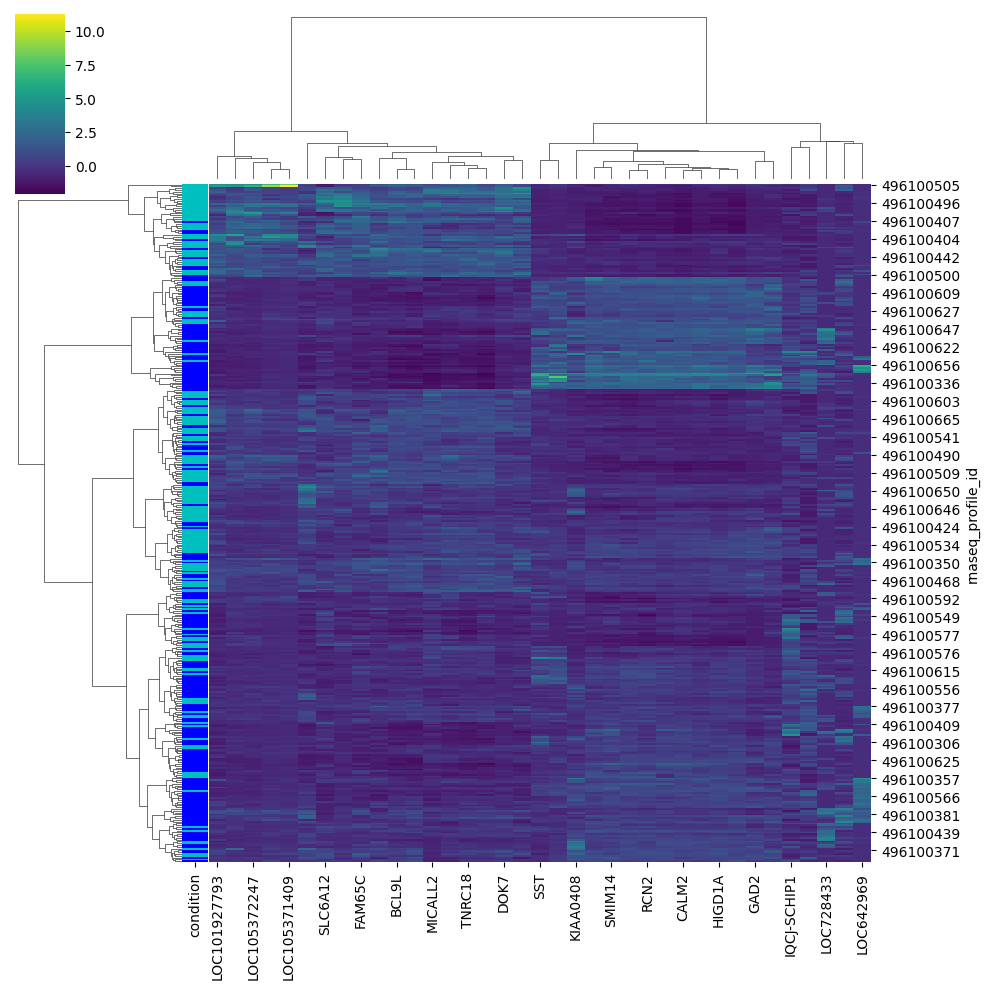

In [39]:
hier=sns.clustermap(test,method='ward',z_score=1,cmap='viridis',row_colors=row_colors)

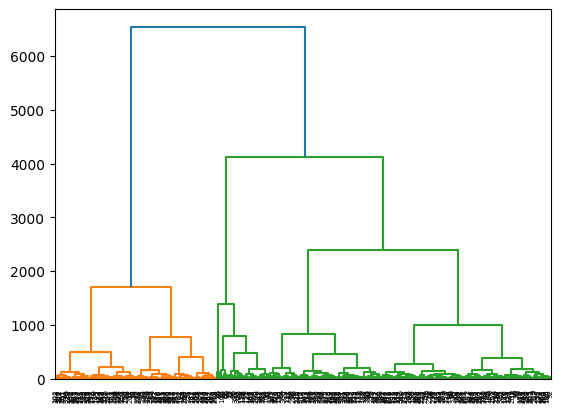

In [40]:
plt.figure()
cls = ward(deg_reads.T)
dendrogram(cls)
plt.show()

In [41]:
query=[entrez_map[x] for x in list(deg_reads.index)]

In [42]:
"""
README.md example https://pypi.org/project/goenrich/
"""

import goenrich

# build the ontology
ont = goenrich.obo.ontology('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data/raw//go-basic.obo')

# use all entrez geneid associations form gene2go as background
# use goenrich.read.goa('db/gene_association.goa_human.gaf.gz') for uniprot
gene2go = goenrich.read.gene2go('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data/raw//gene2go')
values = {k: set(v) for k,v in gene2go.groupby('GO_ID')['GeneID']}

# propagate the background through the ontology
background_attribute = 'gene2go'
goenrich.enrich.propagate(ont, values, background_attribute)

# extract some list of entries as example query
query = gene2go[gene2go['GeneID'].isin(query)]['GeneID'].unique()

# for additional export to graphviz just specify the gvfile argument
# the show argument keeps the graph reasonably small
df = goenrich.enrich.analyze(ont, query, background_attribute, gvfile='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.dot')

# generate html
df.dropna().head().to_html('example.html')

# call to graphviz
import subprocess
subprocess.check_call(['dot', '-Tpng', 'C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.dot', '-o', 'C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.png'])

0

In [43]:
import gseapy as gp


In [44]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=[str(x) for x in list(list(deg_reads.index))], # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [45]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Pancreas Beta Cells,1/40,0.071459,0.310783,0,0,14.190883,37.444534,SST
1,MSigDB_Hallmark_2020,DNA Repair,1/150,0.243307,0.310783,0,0,3.693885,5.221058,BCAM
2,MSigDB_Hallmark_2020,Fatty Acid Metabolism,1/158,0.254519,0.310783,0,0,3.504246,4.795141,GAD2
3,MSigDB_Hallmark_2020,UV Response Up,1/158,0.254519,0.310783,0,0,3.504246,4.795141,SLC6A12
4,MSigDB_Hallmark_2020,Xenobiotic Metabolism,1/200,0.310783,0.310783,0,0,2.758794,3.224097,SLC6A12
...,...,...,...,...,...,...,...,...,...,...
62,KEGG_2021_Human,Parkinson disease,1/249,0.371212,0.398209,0,0,2.208221,2.188308,CALM2
63,KEGG_2021_Human,Alzheimer disease,1/369,0.498249,0.524941,0,0,1.479091,1.030417,CALM2
64,KEGG_2021_Human,Olfactory transduction,1/440,0.561255,0.580948,0,0,1.235383,0.713534,CALM2
65,KEGG_2021_Human,Pathways of neurodegeneration,1/475,0.589411,0.599573,0,0,1.142112,0.603756,CALM2


In [46]:
deg_reads_t=deg_reads.T

In [47]:
X_arr=deg_reads_t.to_numpy()
scale_x=StandardScaler()
x=scale_x.fit_transform(X_arr)

for i in range(2,10):
    kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=100, n_init=1, random_state=42)
    kmeans.fit(x)
    print(i, sklearn.metrics.davies_bouldin_score(x, kmeans.labels_), sklearn.metrics.calinski_harabasz_score(x, kmeans.labels_),sklearn.metrics.silhouette_score(x, kmeans.labels_))
kmeans = KMeans(n_clusters = 2, init='k-means++', max_iter=100, n_init=1, random_state=42)
labels_kmeans=kmeans.fit_predict(x)
#ctr=kmeans.cluster_centers_


2 1.3153496930216075 183.46208155330186 0.2731337857591709
3 1.3843771883115876 152.20581682456861 0.22702028940617514
4 1.715047563084368 122.74208621807072 0.15255265211943883
5 1.849496535188387 100.01525005293158 0.13155005767688616
6 1.809346543136792 91.74250764351804 0.133667441617971
7 1.9534369918508603 79.84289600239856 0.11852745597633157
8 1.8264303751605193 76.43865289512891 0.10509150688729593
9 1.8336778021483977 72.08197173317885 0.11052938164593885


In [48]:
from sklearn.decomposition import PCA



In [49]:
pca = PCA()
pca_res = pca.fit_transform(x)
 


biplot code from https://insidelearningmachines.com/biplot/

scatterplot with pca example from https://www.askpython.com/python/examples/plot-k-means-clusters-python

In [50]:
#function to produce biplot
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='b')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  'g',
            'weight': 'bold',
            'size': 12,
            }
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()

In [51]:
dfScores   = pd.DataFrame(pca_res,columns=['PC'+str(i) for i in range(1,deg_reads_t.shape[1]+1)])
dfLoadings = pd.DataFrame(pca.components_,columns=deg_reads_t.columns,index=dfScores.columns)

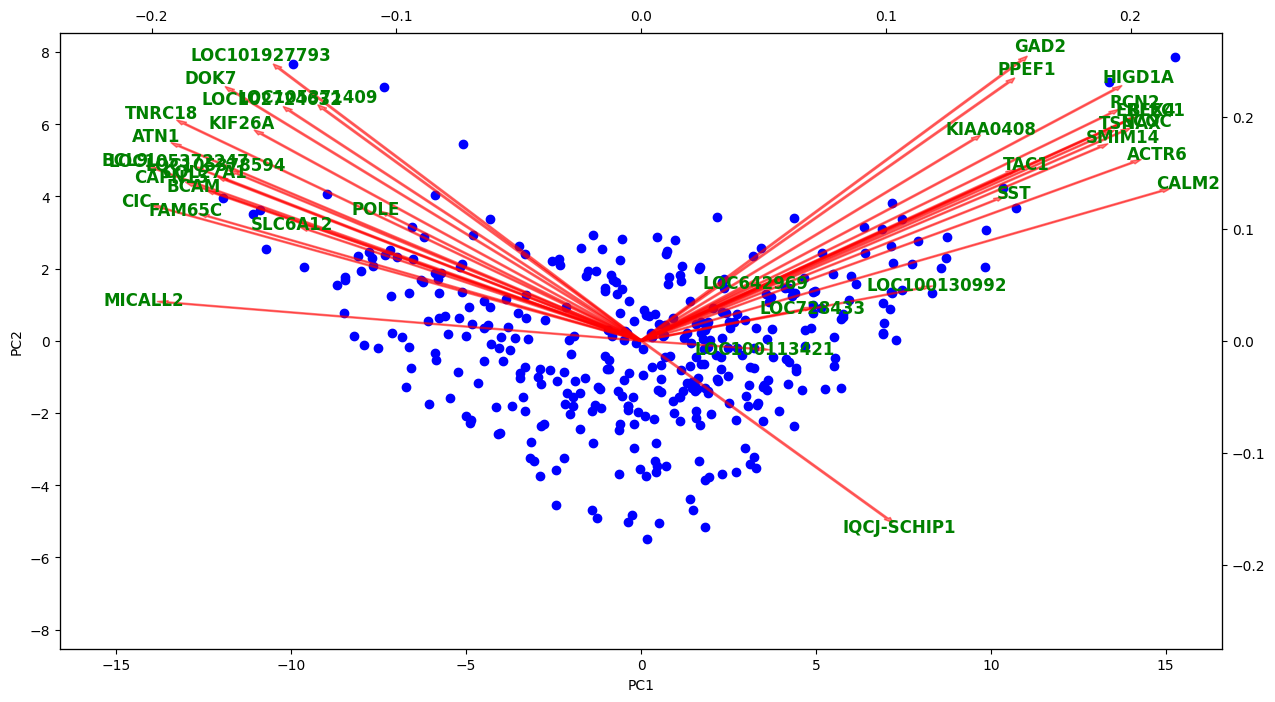

In [52]:
biplot(dfScores, dfLoadings)


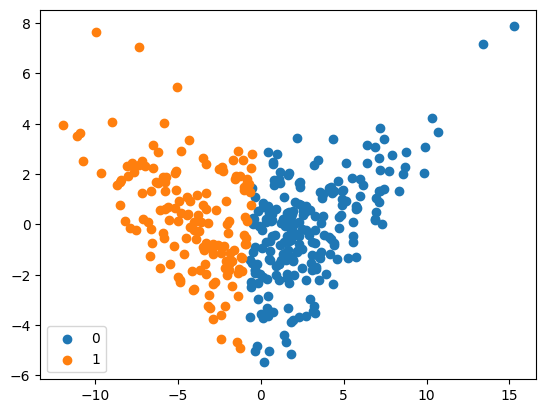

In [73]:
for i in range(0,2):
    plt.scatter(pca_res[labels_kmeans == i , 0] , pca_res[labels_kmeans == i , 1] , label = i)
plt.legend()
plt.show()

In [54]:
hdb = HDBSCAN(min_cluster_size=3)
hdb.fit(x)
db_labels=hdb.labels_

In [55]:
db_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  1,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  1,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0

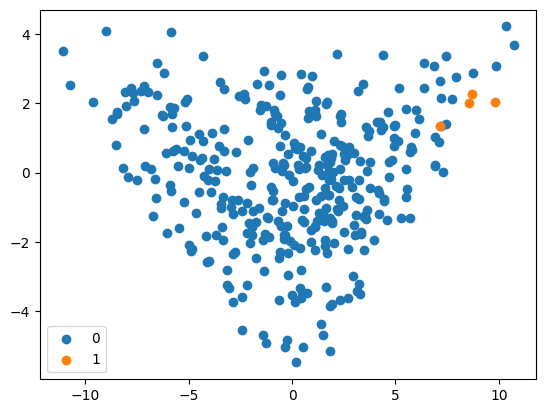

In [75]:
for i in range(max(db_labels)+1):
    plt.scatter(pca_res[db_labels == i , 0] , pca_res[db_labels == i , 1] , label = i)
plt.legend()
plt.show()

In [57]:
import kmedoids
lst=[]
for i in range(1,30):
    km = kmedoids.KMedoids(i, method='fasterpam', metric='euclidean')
    c = km.fit(x)
    lst.append((c.inertia_))
    


([<matplotlib.axis.XTick at 0x19601752460>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29')])

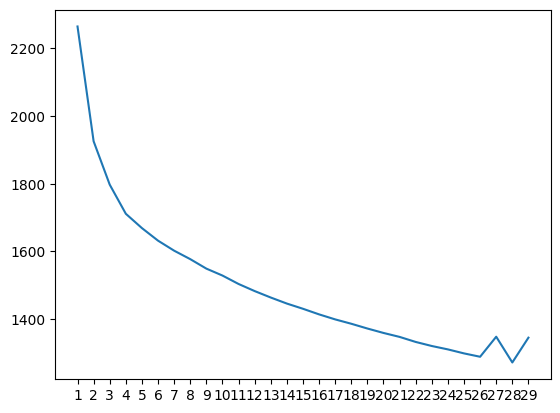

In [58]:
plt.plot([x for x in range(1,30)],lst)
plt.xticks([x for x in range(1,30)])

In [59]:
km = kmedoids.KMedoids(5, method='fasterpam', metric='euclidean')
labels_kmed = km.fit_predict(x)

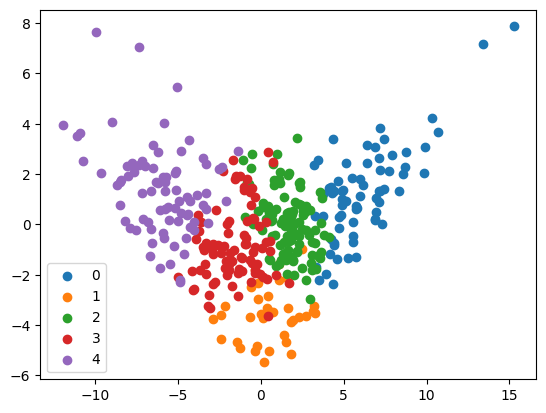

In [60]:
for i in range(5):
    plt.scatter(pca_res[labels_kmed == i , 0] , pca_res[labels_kmed == i , 1] , label = i)
plt.legend()
plt.show()

In [61]:
clustering=deg_reads.T

In [62]:
clustering

symbol,LOC105378594,TSNAX,CALM2,ERLEC1,HIGD1A,IQCJ-SCHIP1,SST,DOK7,SMIM14,SCOC,...,CAPN15,LOC101927793,LOC102724632,LOC105371409,LOC105372247,CIC,BCAM,FAM65C,PPEF1,BEX4
488395315,3.55,22.35,813.21,28.05,68.76,3.62,3.73,1.19,29.94,87.91,...,2.38,0.69,0.82,1.08,1.29,14.09,1.93,2.86,1.68,95.79
496100277,1.59,20.35,605.87,17.88,39.78,5.05,3.14,0.42,24.40,42.53,...,1.00,0.06,0.07,0.06,0.68,8.88,1.14,2.18,0.36,53.56
496100278,1.23,19.68,795.14,26.29,43.82,11.31,2.33,0.22,31.01,56.66,...,1.12,0.03,0.00,0.11,0.23,12.60,1.28,1.49,0.45,70.72
496100279,0.88,24.30,1022.38,36.18,80.39,3.17,9.19,0.53,34.32,100.77,...,1.88,0.55,0.26,0.16,0.19,10.62,0.65,0.96,2.82,137.79
496100281,1.09,25.58,774.91,26.10,64.43,4.81,4.94,0.20,28.92,92.37,...,2.10,0.42,0.08,0.25,0.45,15.95,1.24,1.14,0.68,106.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496100667,1.20,37.04,1318.30,51.13,89.88,3.98,19.54,1.07,46.29,109.07,...,1.63,0.33,0.04,0.17,0.23,9.48,1.80,0.84,3.41,178.43
496100669,1.77,31.46,1099.29,43.78,75.74,3.51,18.81,1.22,42.97,88.85,...,1.78,0.15,0.04,0.16,0.33,9.56,1.07,1.25,3.61,146.27
496100670,2.46,34.02,939.21,32.09,63.12,3.35,2.31,1.80,37.37,72.46,...,3.94,0.70,0.40,0.24,0.67,23.25,2.81,1.78,1.38,122.96
496100671,1.87,31.81,1062.70,30.66,69.80,4.96,21.43,0.45,37.15,106.68,...,2.00,0.06,0.12,0.15,0.34,9.44,1.10,1.71,0.95,132.16


In [63]:
clustering['labels_kmeans']=[str(x) for x in labels_kmeans]
clustering['labels_db']=[str(x) for x in db_labels]
clustering['labels_kmed']=[str(x) for x in labels_kmed]




In [64]:
label_merge['rnaseq_profile_id']=label_merge['rnaseq_profile_id'].astype(str)

In [65]:
clusters_df=clustering.merge(label_merge,how='left',left_index=True, right_on='rnaseq_profile_id')

In [66]:
print(list(clusters_df.columns))

['LOC105378594', 'TSNAX', 'CALM2', 'ERLEC1', 'HIGD1A', 'IQCJ-SCHIP1', 'SST', 'DOK7', 'SMIM14', 'SCOC', 'KIAA0408', 'MICALL2', 'TNRC18', 'TAC1', 'LOC728433', 'LOC100113421', 'COL27A1', 'LOC100130992', 'GAD2', 'BCL9L', 'SLC6A12', 'ATN1', 'LOC642969', 'ACTR6', 'POLE', 'KIF26A', 'RCN2', 'CAPN15', 'LOC101927793', 'LOC102724632', 'LOC105371409', 'LOC105372247', 'CIC', 'BCAM', 'FAM65C', 'PPEF1', 'BEX4', 'labels_kmeans', 'labels_db', 'labels_kmed', 'structure_name', 'rnaseq_profile_id', 'age', 'sex', 'apo_e4_allele', 'education_years', 'age_at_first_tbi', 'longest_loc_duration', 'cerad', 'num_tbi_w_loc', 'dsm_iv_clinical_diagnosis', 'control_set', 'nincds_arda_diagnosis', 'ever_tbi_w_loc', 'race', 'hispanic', 'act_demented', 'braak', 'nia_reagan']


In [67]:
import plotly.express as px

In [69]:
#clusters_df['age']=clusters_df['age'].astype(int)
clusters_df['braak']=clusters_df['braak'].astype(int)



In [70]:
gb=clusters_df.groupby(by=['labels_kmeans'])['braak'].mean().reset_index()
gb

,labels_kmeans,braak
0,0,3.271111
1,1,3.888158


In [71]:
for i in ['sex','dsm_iv_clinical_diagnosis','nincds_arda_diagnosis','control_set','ever_tbi_w_loc','age','structure_name','act_demented']:
    for y in ['labels_kmed','labels_kmeans','labels_db']:

        gb=clusters_df.groupby(by=[i,y]).count().reset_index()
        fig=px.bar(gb,x=y,y='SST',color=i)
        fig.show()

for i in ['braak','nia_reagan']:
    for y in ['labels_kmed','labels_kmeans','labels_db']:

        gb=clusters_df.groupby(by=[y])[i].mean().reset_index()
        fig=px.bar(gb,x=y,y=i)
        fig.show()
